In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels
import os
import sys
from os import listdir
from os.path import isfile, join
import functools 
from matplotlib_venn import venn3
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 600

In [2]:
expression_file = "/data8t/mtx/scSNV/dataset_v2/GSE57872/data/quantification_stats/gene_expression_matrix/gene_expression_matrix_cpm.csv"
exp_profile = pd.read_csv(expression_file,index_col=0)
reads_file = "/data8t/mtx/scSNV/dataset_v2/GSE57872/data/quantification_stats/gene_expression_matrix/gene_expression_matrix.csv"
reads_profile = pd.read_csv(reads_file,index_col=0)

In [3]:
pvalue_cellline = pd.read_csv('third_cellline.csv',index_col=0)
pvalue_patients = pd.read_csv('third_patients.csv',index_col=0)
pvalue_all = pd.read_csv('third_all.csv',index_col=0)

gene_patients = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_third_cpm_patients.csv', index_col=0)
snv_patients = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_final_snv_MGH.csv', index_col=0)

gene_cellline = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_third_cpm_cellline.csv', index_col=0)
snv_cellline = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_final_snv_CSC.csv', index_col=0)

gene_all = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_third_cpm_all.csv', index_col=0)
snv_all = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_snv_on_filtered_genes_pass_40_cells.csv', index_col=0)


label_all = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_cellline_patient_label.csv', index_col=0)


# Filter out all-non-zero genes

In [11]:
all_nonzero_gene_all = (gene_all > 0).sum(axis = 1)[(gene_all > 0).sum(axis = 1) == gene_all.shape[1]].index.values
all_nonzero_gene_cellline = (gene_cellline > 0).sum(axis = 1)[(gene_cellline > 0).sum(axis = 1) == gene_cellline.shape[1]].index.values
all_nonzero_gene_patients = (gene_patients > 0).sum(axis = 1)[(gene_patients > 0).sum(axis = 1) == gene_patients.shape[1]].index.values

In [15]:
gene_all_filtered = gene_all.loc[~gene_all.index.isin(all_nonzero_gene_all),]
gene_cellline_filtered = gene_cellline.loc[~gene_cellline.index.isin(all_nonzero_gene_cellline),]
gene_patients_filtered = gene_patients.loc[~gene_patients.index.isin(all_nonzero_gene_patients),]
pvalue_all_filtered = pvalue_all.loc[~pvalue_all.index.isin(all_nonzero_gene_all),]
pvalue_cellline_filtered = pvalue_cellline.loc[~pvalue_cellline.index.isin(all_nonzero_gene_cellline),]
pvalue_patients_filtered = pvalue_patients.loc[~pvalue_patients.index.isin(all_nonzero_gene_patients),]

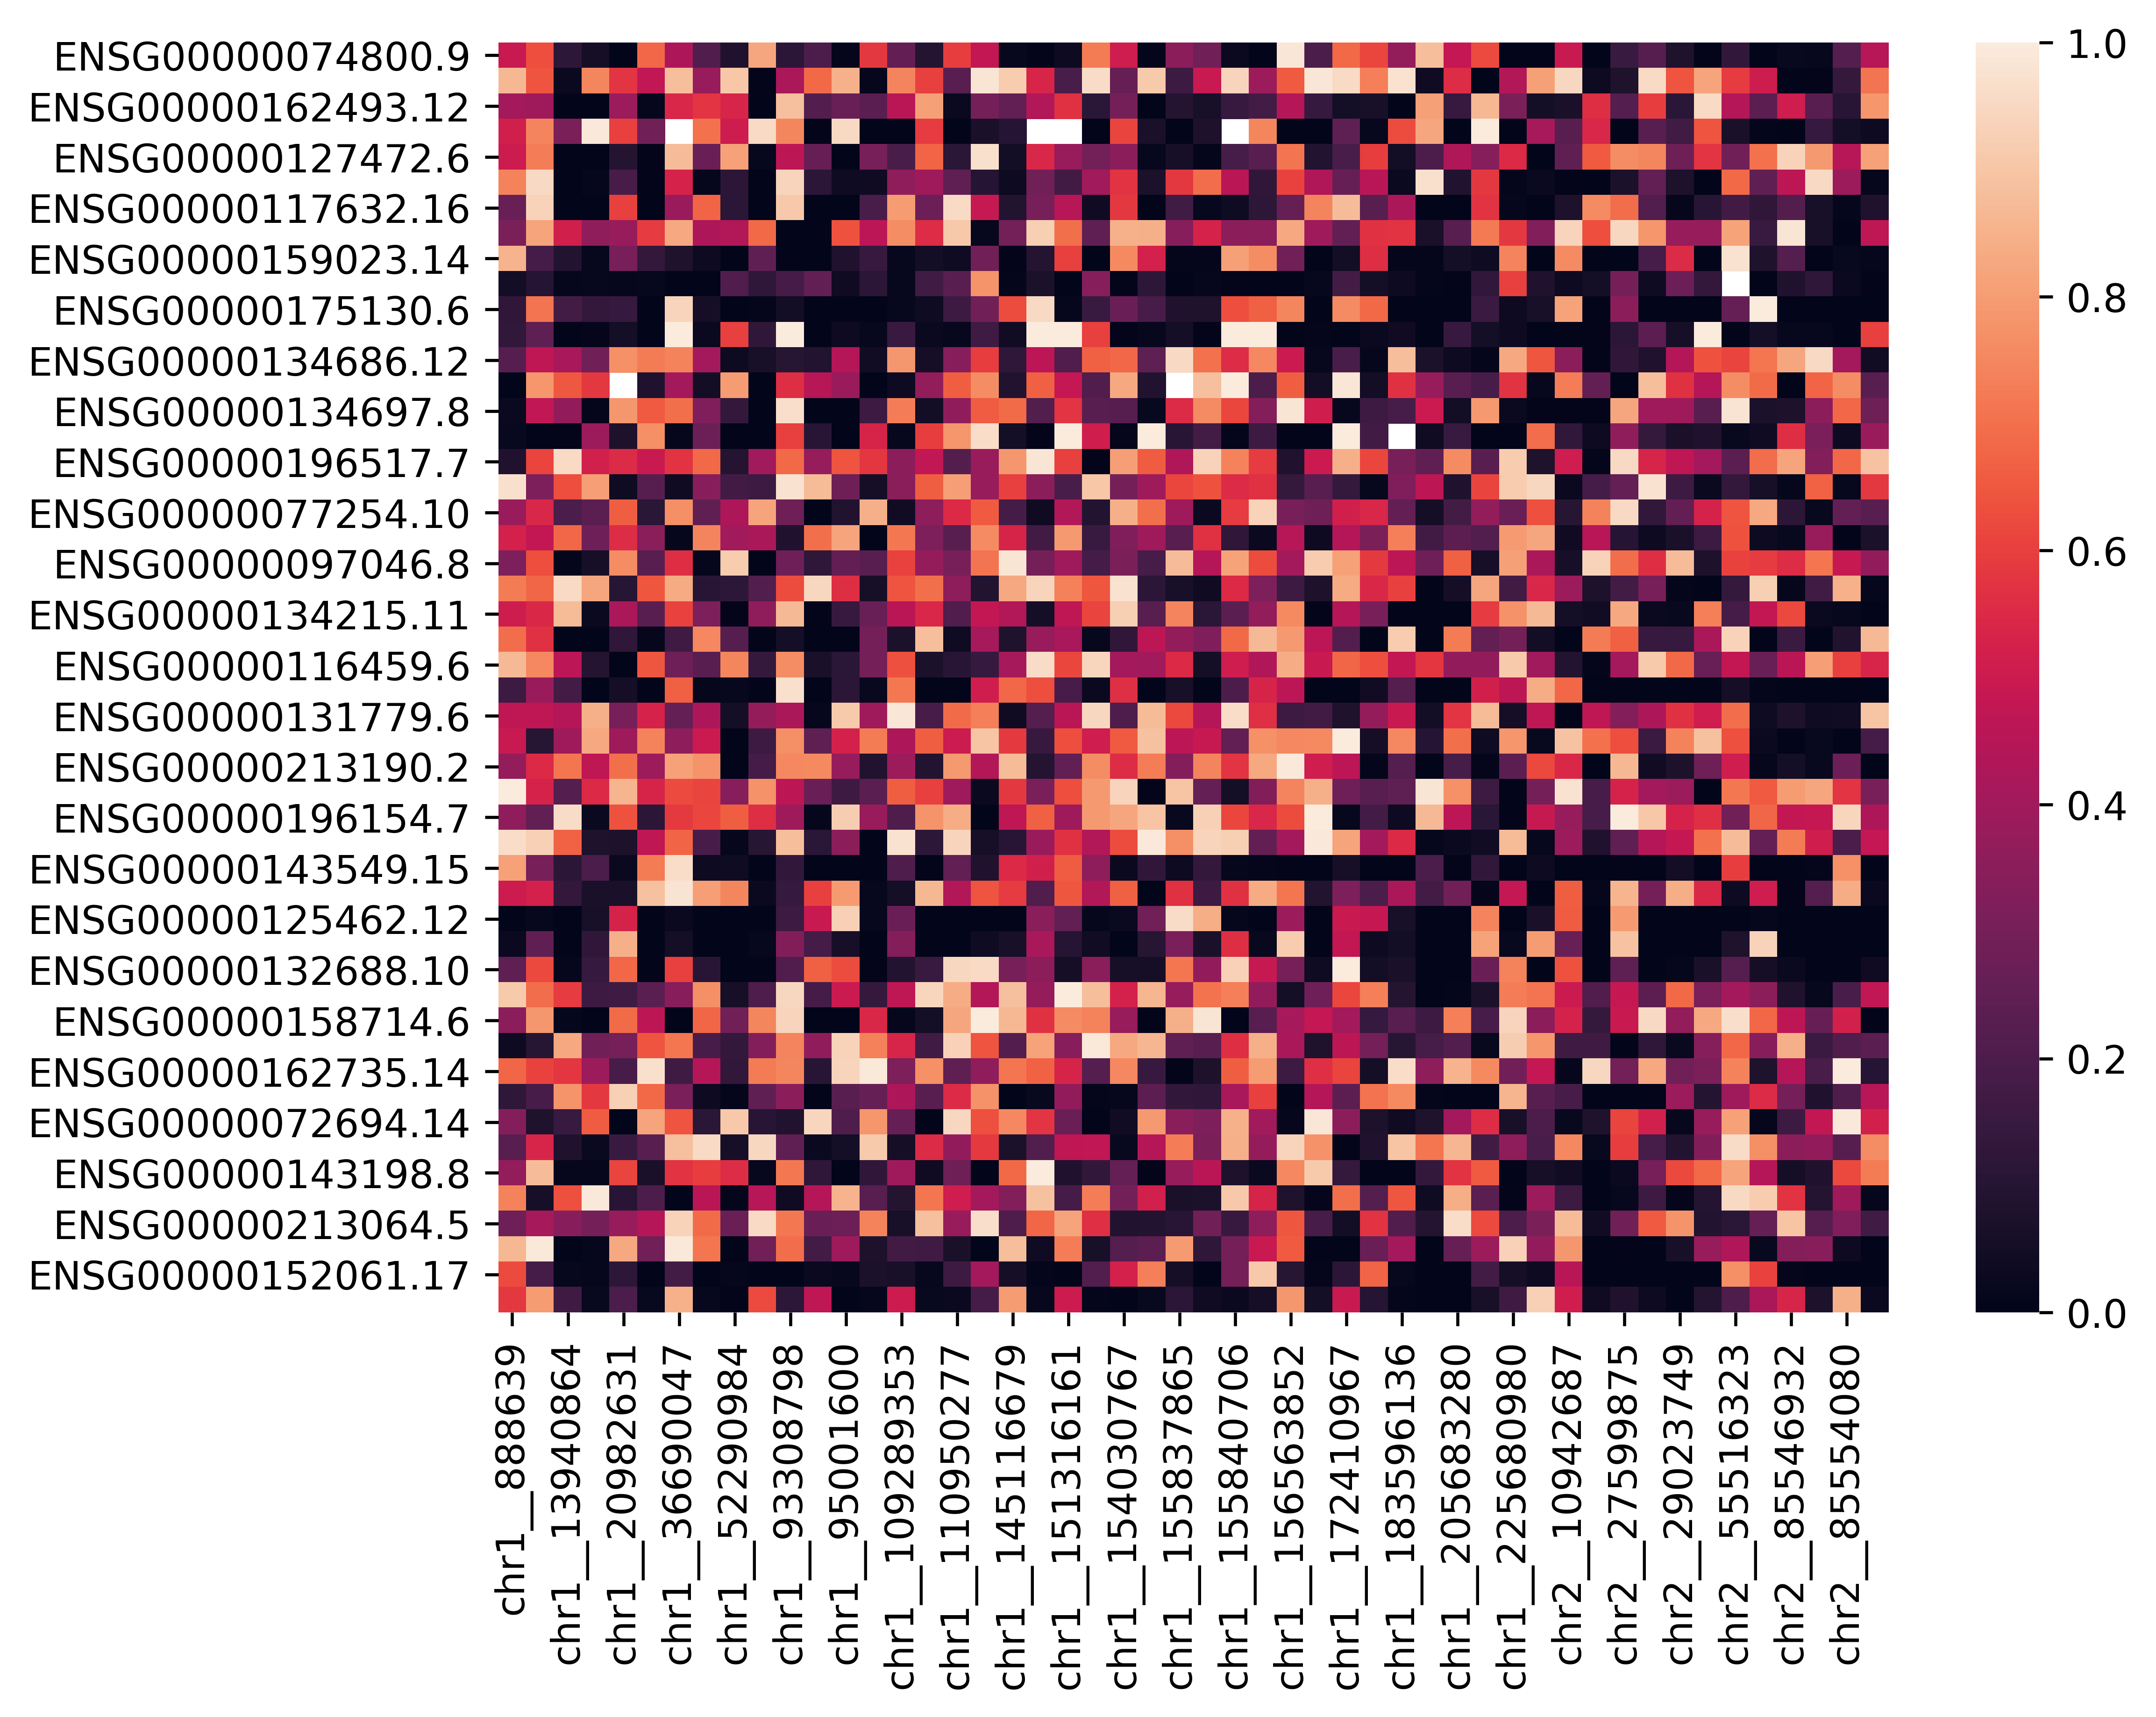

In [16]:
sns.heatmap(pvalue_all.iloc[:50,:50])

# Filter out too-many-zeros genes

In [18]:
gene_all_filtered = gene_all_filtered.loc[(gene_all_filtered > 2).sum(axis=1)[(gene_all_filtered > 2).sum(axis=1) > 30].index.values,]
gene_patients_filtered = gene_patients_filtered.loc[(gene_patients_filtered > 2).sum(axis=1)[(gene_patients_filtered > 2).sum(axis=1) > 20].index.values,]
gene_cellline_filtered = gene_cellline_filtered.loc[(gene_cellline_filtered > 2).sum(axis=1)[(gene_cellline_filtered > 2).sum(axis=1) > 20].index.values,]

In [19]:
pvalue_all_filtered = pvalue_all_filtered.loc[gene_all_filtered.index.values, ]
pvalue_cellline_filtered = pvalue_cellline_filtered.loc[gene_cellline_filtered.index.values, ]
pvalue_patients_filtered = pvalue_patients_filtered.loc[gene_patients_filtered.index.values, ]

# Select SNVs

In [20]:
def select_snv(df,threshold = 20):
    # input is a snv matrix, snv*samples
    tmp_df = df.copy(deep=True)
    snv_yes = set((tmp_df == 1).sum(axis=1)[(tmp_df == 1).sum(axis=1) >= threshold].index.values)
    snv_no = set((tmp_df == 0).sum(axis=1)[(tmp_df == 0).sum(axis=1) >= threshold].index.values)
    snv_valid = snv_yes.intersection(snv_no)
    #tmp_df = tmp_df.loc[snv_valid,:]
    return snv_valid

In [21]:
snv_valid_all = select_snv(snv_all)
snv_valid_cellline = select_snv(snv_cellline)
snv_valid_patients = select_snv(snv_patients)

In [22]:
len(snv_valid_all)

3513

In [23]:
len(snv_valid_cellline)

1846

In [24]:
len(snv_valid_patients)

3231

In [25]:
pvalue_all_filtered = pvalue_all_filtered.loc[:,snv_valid_all]
pvalue_cellline_filtered = pvalue_cellline_filtered.loc[:,snv_valid_cellline]
pvalue_patients_filtered = pvalue_patients_filtered.loc[:,snv_valid_patients]

In [26]:
pvalue_all_filtered

,chr10__99219885,chr7__55248926,chr19__18418044,chr2__120439230,chr5__82789647,chr3__450534,chr14__24909475,chr1__10502710,chr11__13344951,chr1__40539228,...,chr12__57995089,chr15__45010022,chr13__25825889,chr20__1099523,chr12__49065727,chr2__26455127,chr2__27435374,chr13__67782181,chr14__64882380,chr4__77081836
ENSG00000074800.9,0.001089,0.062218,5.237835e-02,0.001003,0.674148,0.719817,0.239539,7.188603e-01,4.877461e-01,0.390251,...,0.036813,0.012076,0.129635,0.001629,0.000008,0.330307,0.234117,0.003805,0.000557,0.683204
ENSG00000028137.12,0.660621,0.778363,5.198872e-01,0.851345,0.016387,0.377867,0.570169,1.974950e-02,1.573756e-15,0.704404,...,0.215692,0.005658,0.588328,0.135609,0.921586,0.002315,0.935556,0.798526,0.035506,0.000788
ENSG00000162493.12,0.546092,0.887210,2.145778e-01,0.104020,0.830462,0.911479,0.611527,1.986677e-01,1.692568e-01,0.452559,...,0.220047,0.847466,0.177409,0.163030,0.395514,0.190740,0.716242,0.641908,0.015229,0.053948
ENSG00000127472.6,0.523155,0.423411,7.518685e-02,0.180087,0.837964,0.411329,0.664085,1.811244e-02,8.140301e-01,0.796563,...,0.715950,0.612188,0.551868,0.453631,0.786074,0.866027,0.645290,0.157963,0.059495,0.983777
ENSG00000070831.11,0.187068,0.040637,1.641990e-10,0.000912,0.359440,0.671487,0.046206,9.139815e-07,1.560644e-02,0.223846,...,0.505551,0.121231,0.121385,0.000002,0.076698,0.004991,0.001554,0.814102,0.000126,0.906891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000165704.10,0.081165,0.917554,1.618107e-02,0.171130,0.749014,0.576197,0.540271,4.117638e-01,1.471668e-01,0.189266,...,0.023610,0.446196,0.246840,0.322328,0.078305,0.011759,0.343871,0.304448,0.065667,0.672988
ENSG00000029993.10,0.694319,0.367973,5.967913e-01,0.227078,0.047912,0.334199,0.824904,6.584853e-01,6.708498e-02,0.053056,...,0.202467,0.011850,0.698864,0.579379,0.782922,0.029276,0.953682,0.732925,0.407531,0.114708
ENSG00000011677.8,0.000075,0.442502,8.962732e-02,0.000118,0.405781,0.163248,0.762585,2.206028e-01,1.123417e-03,0.906018,...,0.758408,0.030428,0.220709,0.085357,0.002236,0.808343,0.009508,0.079116,0.047129,0.804600
ENSG00000172534.9,0.019662,0.212017,8.349187e-01,0.017465,0.171492,0.810426,0.411029,2.877922e-02,5.729396e-01,0.139218,...,0.506641,0.001451,0.006805,0.601512,0.026975,0.392337,0.059427,0.452605,0.010791,0.088332


# Adjust p-value

In [27]:
def df2col(df):
    #df is pvalue dataframe
    row_num = df.shape[0]
    col_num = df.shape[1]
    tmp = 0
    tmp_index_list = []
    for i in range(row_num):
        for j in range(col_num):
            tmp = tmp +1
            k = df.index.values[i] + "____" + df.columns.values[j]
            tmp_index_list.append(k)
    df_one_column = pd.DataFrame({'pvalue':df.values.reshape(-1)})
    df_one_column.index = tmp_index_list
    return df_one_column
    

In [38]:
pvalue_all_col = df2col(pvalue_all_filtered)
pvalue_cellline_col = df2col(pvalue_cellline_filtered)
pvalue_patients_col = df2col(pvalue_patients_filtered)
#remove nan value
pvalue_all_col_valid = pvalue_all_col.loc[~pvalue_all_col.isna().pvalue,]
pvalue_cellline_col_valid = pvalue_cellline_col.loc[~pvalue_cellline_col.isna().pvalue,]
pvalue_patients_col_valid = pvalue_patients_col.loc[~pvalue_patients_col.isna().pvalue,]

pvalue_all_adjusted = statsmodels.stats.multitest.multipletests(pvalue_all_col_valid.pvalue.values,alpha=0.05)
pvalue_cellline_adjusted = statsmodels.stats.multitest.multipletests(pvalue_cellline_col_valid.pvalue.values,alpha=0.05)
pvalue_patients_adjusted = statsmodels.stats.multitest.multipletests(pvalue_patients_col_valid.pvalue.values,alpha=0.05)

pvalue_all_col_final = pvalue_all_col_valid.copy(deep=True)
pvalue_all_col_final['pvalue_adj'] = pvalue_all_adjusted[1]

pvalue_cellline_col_final = pvalue_cellline_col_valid.copy(deep=True)
pvalue_cellline_col_final['pvalue_adj'] = pvalue_cellline_adjusted[1]

pvalue_patients_col_final = pvalue_patients_col_valid.copy(deep=True)
pvalue_patients_col_final['pvalue_adj'] = pvalue_patients_adjusted[1]

pair_all = set(pvalue_all_col_final[pvalue_all_col_final['pvalue_adj']<0.01].index.values)
pair_cellline = set(pvalue_cellline_col_final[pvalue_cellline_col_final['pvalue_adj']<0.01].index.values)
pair_patients = set(pvalue_patients_col_final[pvalue_patients_col_final['pvalue_adj']<0.01].index.values)

In [39]:
len(pair_patients)

9392

# Result

In [40]:
# only
only_all = pair_all - pair_cellline - pair_patients 
only_cellline = pair_cellline -  pair_patients - pair_all
only_patients = pair_patients -  pair_cellline - pair_all
# all
all_all = pair_all.intersection(pair_cellline).intersection(pair_patients)
# two
two_all__cellline = pair_all.intersection(pair_cellline) - all_all
two_all__patients = pair_all.intersection(pair_patients) - all_all
two_cellline__patients = pair_cellline.intersection(pair_patients) - all_all

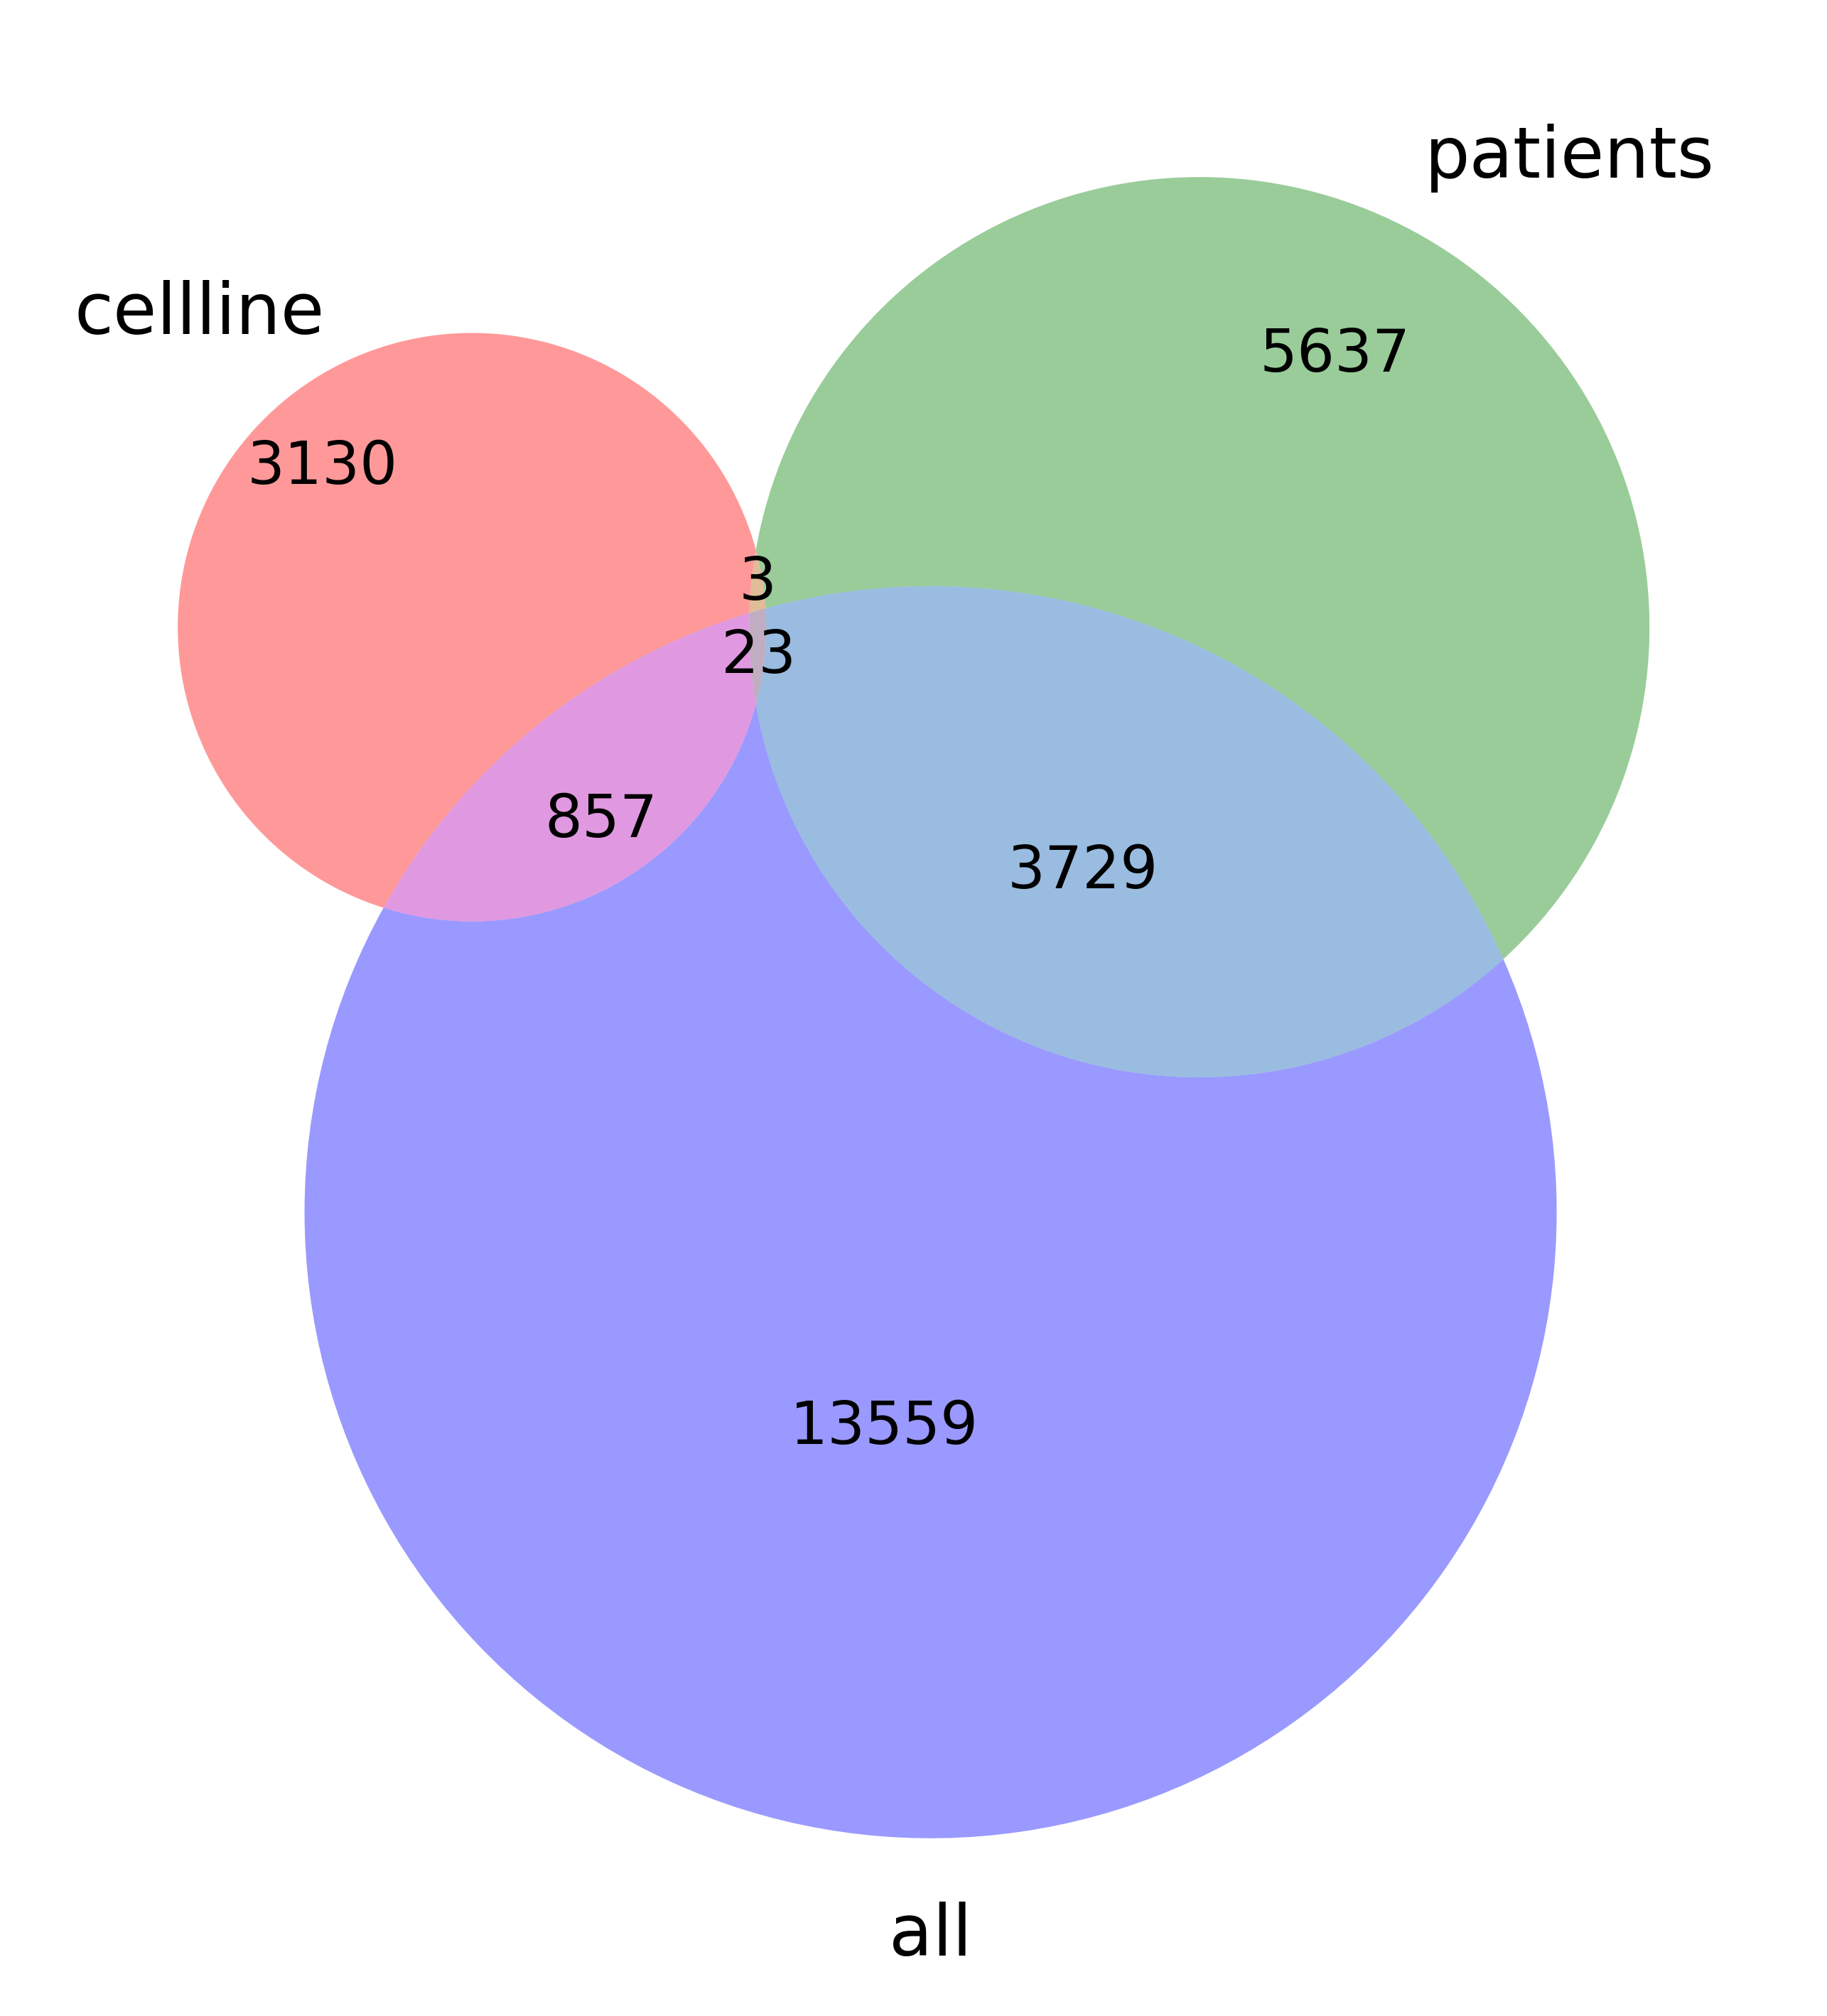

In [41]:
venn3(subsets = (len(only_cellline), len(only_patients), len(two_cellline__patients), 
                 len(only_all),len(two_all__cellline),
                 len(two_all__patients),len(all_all)),
      set_labels = ('cellline', 'patients', 'all'))

In [42]:
# filter furthur
pair_cellline_filtered = set()
for i in only_cellline:
    gene_id = i.split('____')[0]
    snv_id = i.split('____')[1]
    df_tmp = pd.DataFrame({'gene':gene_cellline.loc[gene_id,:],'snv':snv_cellline.loc[snv_id,:]})
    if((df_tmp[df_tmp.gene > 0].snv.value_counts() >30).sum() == 2):
        pair_cellline_filtered.add(i)

# filter furthur
pair_patients_filtered = set()
for i in only_patients:
    gene_id = i.split('____')[0]
    snv_id = i.split('____')[1]
    df_tmp = pd.DataFrame({'gene':gene_patients.loc[gene_id,:],'snv':snv_patients.loc[snv_id,:]})
    if((df_tmp[df_tmp.gene > 0].snv.value_counts() >30).sum() == 2):
        pair_patients_filtered.add(i)

# filter furthur
pair_all_filtered = set()
for i in only_all:
    gene_id = i.split('____')[0]
    snv_id = i.split('____')[1]
    df_tmp = pd.DataFrame({'gene':gene_all.loc[gene_id,:],'snv':snv_all.loc[snv_id,:]})
    if((df_tmp[df_tmp.gene > 0].snv.value_counts() >30).sum() == 2):
        pair_all_filtered.add(i)


In [43]:
len(pair_cellline_filtered)

1744

In [44]:
# only
only_all_filtered = pair_all_filtered - pair_patients_filtered - pair_cellline_filtered 
only_patients_filtered = pair_patients_filtered -  pair_cellline_filtered - pair_all_filtered
only_cellline_filtered = pair_cellline_filtered -  pair_patients_filtered - pair_all_filtered
# all
all_all_filtered = pair_all_filtered.intersection(pair_patients_filtered).intersection(pair_cellline_filtered)
# two
two_all__patients_filtered = pair_all_filtered.intersection(pair_patients_filtered) - all_all_filtered
two_all__cellline_filtered = pair_all_filtered.intersection(pair_cellline_filtered) - all_all_filtered
two_patients__cellline_filtered = pair_patients_filtered.intersection(pair_cellline_filtered) - all_all_filtered

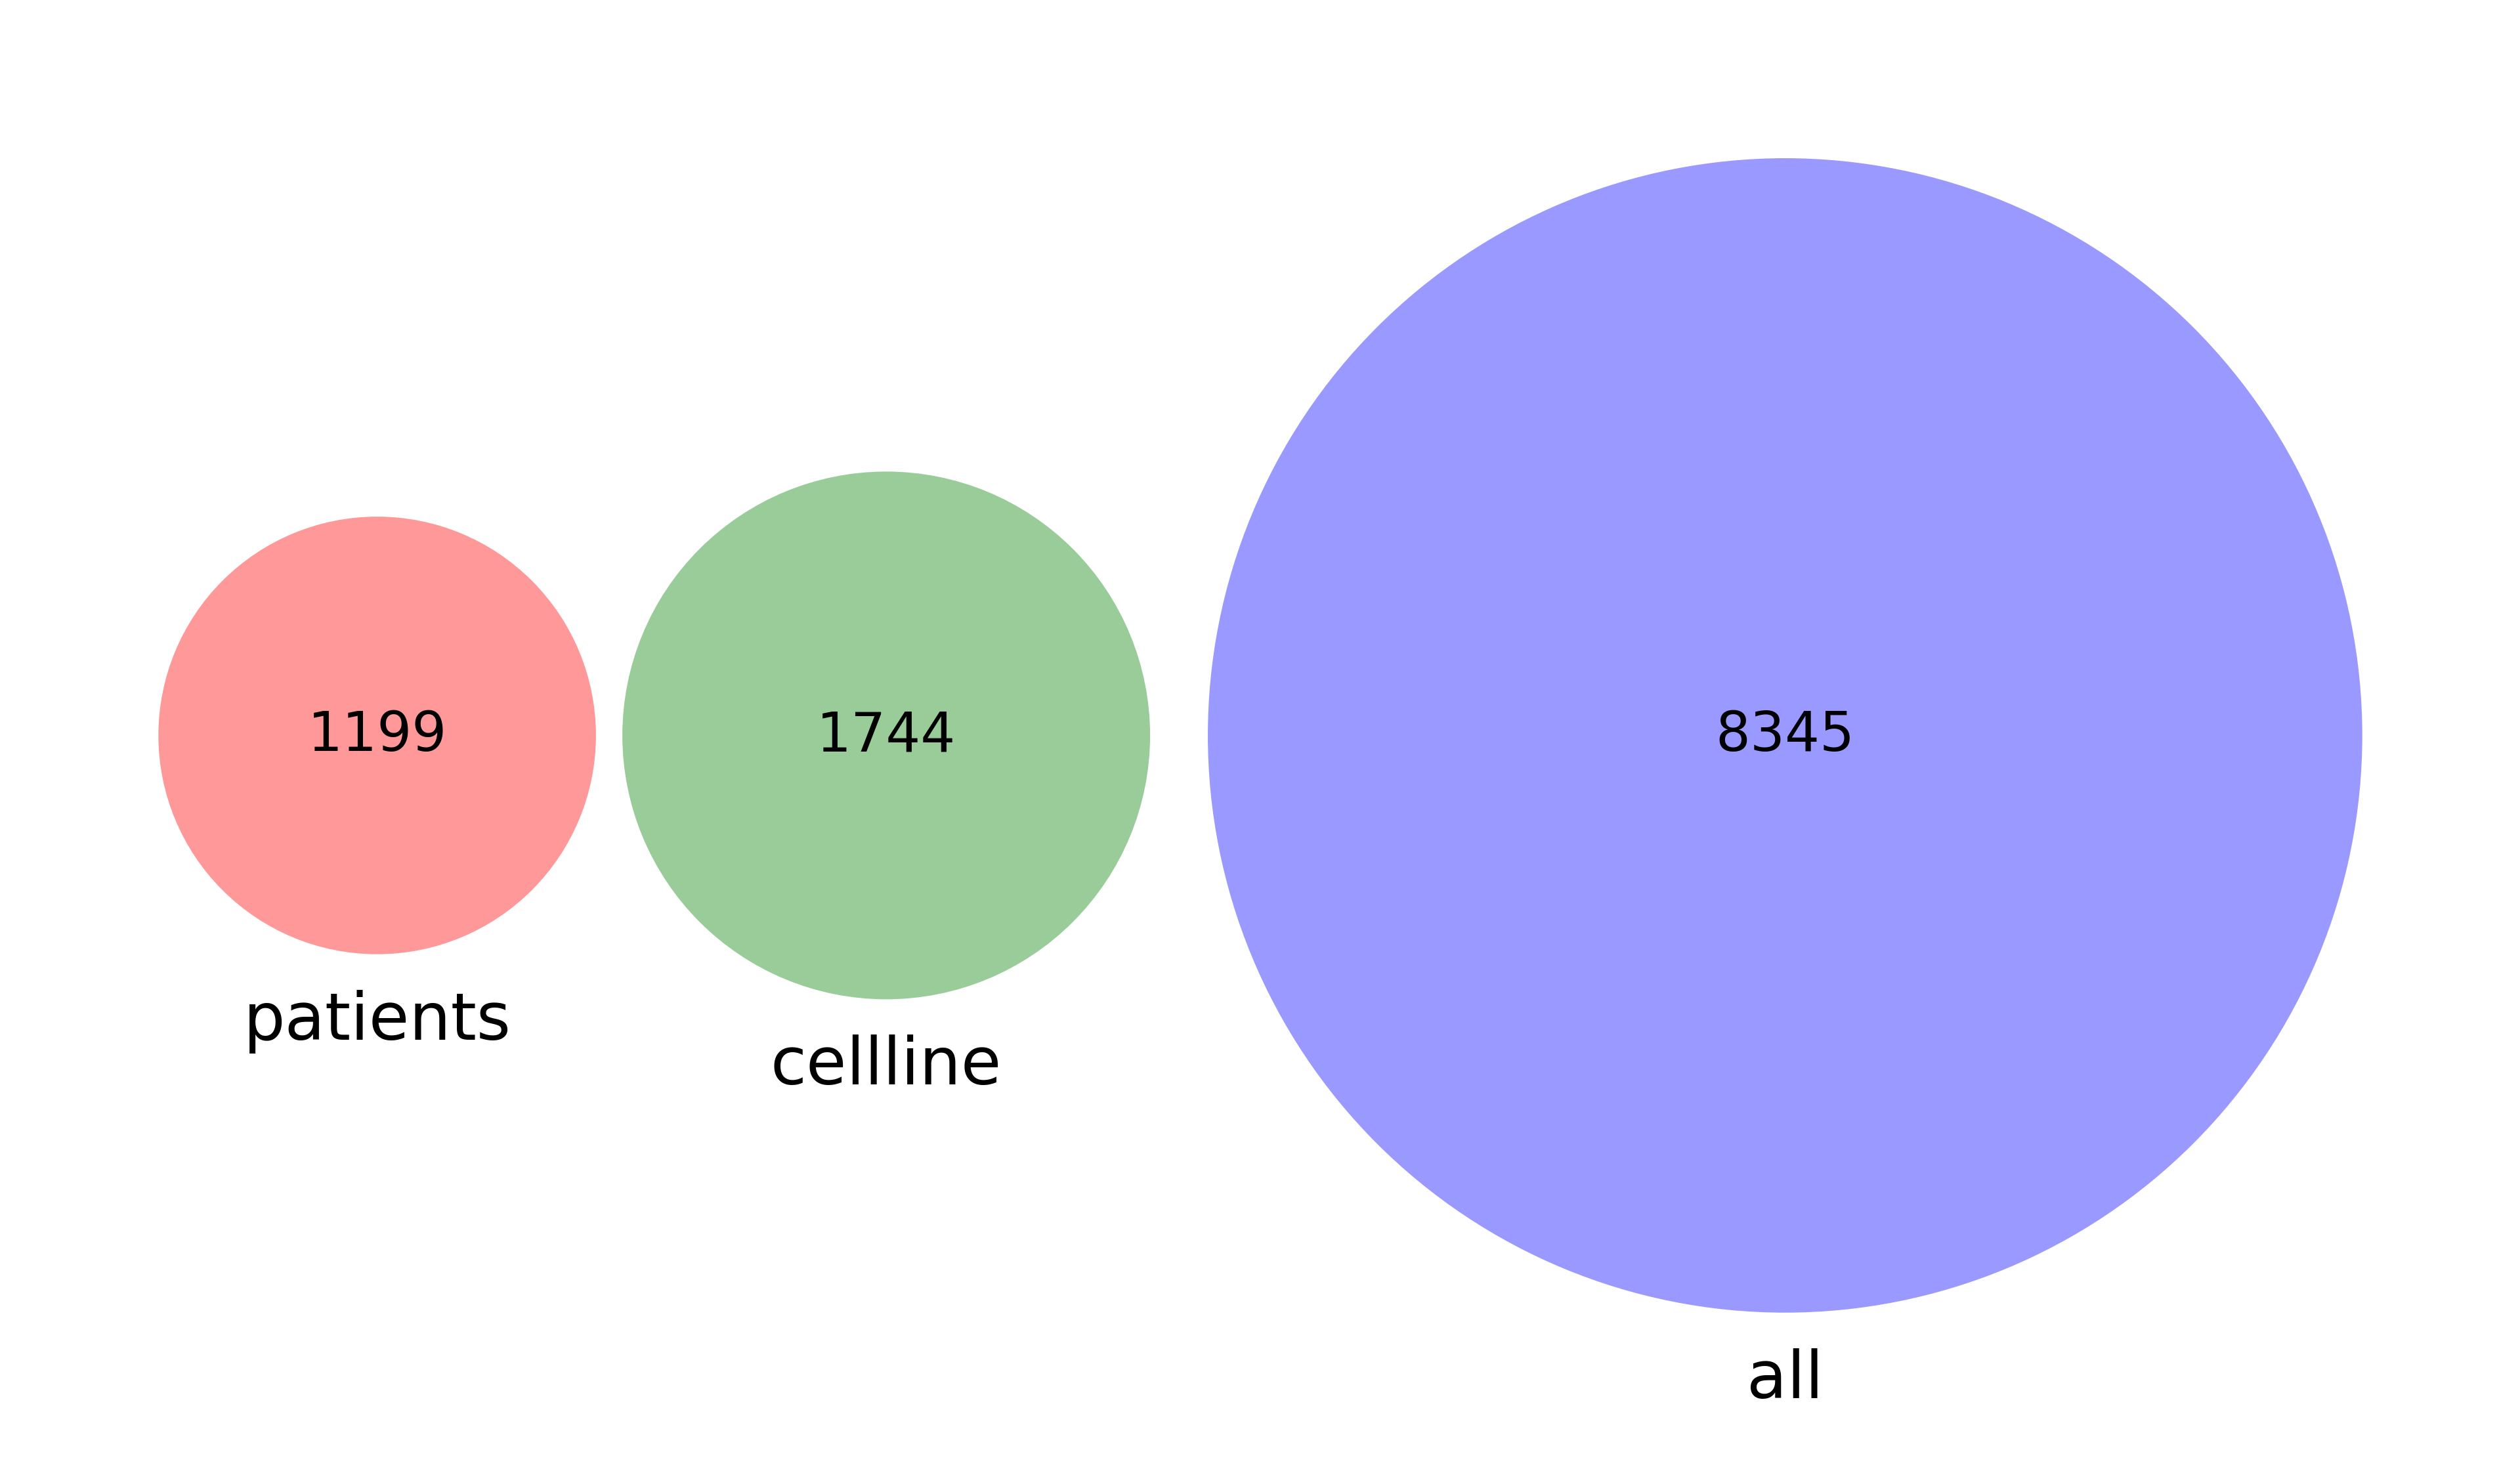

In [45]:
venn3(subsets = (len(only_patients_filtered), len(only_cellline_filtered), len(two_patients__cellline_filtered), 
                 len(only_all_filtered),len(two_all__patients_filtered),
                 len(two_all__cellline_filtered),len(all_all_filtered)),
      set_labels = ('patients', 'cellline', 'all'))

# Save Result

In [48]:
gtf_index_df = pd.read_csv("/data8t/mtx/scSNV/dataset_v1/kim/data/gtf_index/GTF_index.csv", index_col='Geneid')

In [49]:
def search_snv_from_gtfindex(snv_list, gtf_index_df):
    # snv_list can be list or numpy array
    # for str, try to convert it to list(with only one snv)
    # each item in snv_list is named like chr7_123
    if isinstance(snv_list, str):
        snv_list = [snv_list]
    snv_location = defaultdict(list)
    j = 0
    for i in snv_list:
        j += 1
        if j%5000 == 0:
            print(j)
        chrom = i.split("__")[0]
        pos = int(i.split("__")[1])
        result_df = gtf_index_df[(gtf_index_df['chr'] == chrom) & (gtf_index_df['start'] <= pos) & (gtf_index_df['end'] >= pos)]
        gene_id_list = list(result_df.index.values)
        snv_location[i] = gene_id_list
    return snv_location

In [65]:
only_patients_filtered_df = pd.DataFrame(only_patients_filtered)
only_patients_filtered_df = only_patients_filtered_df.iloc[:,0].str.split('____', expand = True)
only_patients_filtered_df.columns = ['gene','snv']
only_patients_filtered_df['genename'] = only_patients_filtered_df['gene']
only_patients_filtered_df['snv_located_gene'] = only_patients_filtered_df['snv']
only_patients_filtered_df['snv_located_gene_name'] = only_patients_filtered_df['snv']
only_patients_filtered_df['distance_snv_gene'] = only_patients_filtered_df['snv']
for i in range(only_patients_filtered_df.shape[0]):
    only_patients_filtered_df['genename'].values[i] = gtf_index_df.loc[only_patients_filtered_df['genename'].values[i],'gene_name']
    only_patients_filtered_df['snv_located_gene'].values[i] = search_snv_from_gtfindex(only_patients_filtered_df['snv_located_gene'].values[i],gtf_index_df)[only_patients_filtered_df['snv_located_gene'].values[i]]
    tmp_gene_name = list()
    for gene_id in only_patients_filtered_df['snv_located_gene'].values[i]:
        tmp_gene_name.append(gtf_index_df.loc[gene_id,'gene_name'])
    only_patients_filtered_df['snv_located_gene_name'].values[i] = tmp_gene_name
    # snv and gene distance
    if gtf_index_df.loc[only_patients_filtered_df['gene'].values[i],'chr'] != only_patients_filtered_df['snv'].values[i].split('__')[0]:
        only_patients_filtered_df['distance_snv_gene'].values[i] = 0
    else:
        only_patients_filtered_df['distance_snv_gene'].values[i] = int(gtf_index_df.loc[only_patients_filtered_df['gene'].values[i],'start']) - int(only_patients_filtered_df['snv'].values[i].split('__')[-1])
only_patients_filtered_df.to_csv('./positive_result_third_patients.csv')

In [73]:
only_cellline_filtered_df = pd.DataFrame(only_cellline_filtered)
only_cellline_filtered_df = only_cellline_filtered_df.iloc[:,0].str.split('____', expand = True)
only_cellline_filtered_df.columns = ['gene','snv']
only_cellline_filtered_df['genename'] = only_cellline_filtered_df['gene']
only_cellline_filtered_df['snv_located_gene'] = only_cellline_filtered_df['snv']
only_cellline_filtered_df['snv_located_gene_name'] = only_cellline_filtered_df['snv']
only_cellline_filtered_df['distance_snv_gene'] = only_cellline_filtered_df['snv']
for i in range(only_cellline_filtered_df.shape[0]):
    only_cellline_filtered_df['genename'].values[i] = gtf_index_df.loc[only_cellline_filtered_df['genename'].values[i],'gene_name']
    only_cellline_filtered_df['snv_located_gene'].values[i] = search_snv_from_gtfindex(only_cellline_filtered_df['snv_located_gene'].values[i],gtf_index_df)[only_cellline_filtered_df['snv_located_gene'].values[i]]
    tmp_gene_name = list()
    for gene_id in only_cellline_filtered_df['snv_located_gene'].values[i]:
        tmp_gene_name.append(gtf_index_df.loc[gene_id,'gene_name'])
    only_cellline_filtered_df['snv_located_gene_name'].values[i] = tmp_gene_name
    # snv and gene distance
    if gtf_index_df.loc[only_cellline_filtered_df['gene'].values[i],'chr'] != only_cellline_filtered_df['snv'].values[i].split('__')[0]:
        only_cellline_filtered_df['distance_snv_gene'].values[i] = 0
    else:
        only_cellline_filtered_df['distance_snv_gene'].values[i] = int(gtf_index_df.loc[only_cellline_filtered_df['gene'].values[i],'start']) - int(only_cellline_filtered_df['snv'].values[i].split('__')[-1])
only_cellline_filtered_df.to_csv('./positive_result_third_cellline.csv')

In [78]:
only_all_filtered_df = pd.DataFrame(only_all_filtered)
only_all_filtered_df = only_all_filtered_df.iloc[:,0].str.split('____', expand = True)
only_all_filtered_df.columns = ['gene','snv']
only_all_filtered_df['genename'] = only_all_filtered_df['gene']
only_all_filtered_df['snv_located_gene'] = only_all_filtered_df['snv']
only_all_filtered_df['snv_located_gene_name'] = only_all_filtered_df['snv']
only_all_filtered_df['distance_snv_gene'] = only_all_filtered_df['snv']
for i in range(only_all_filtered_df.shape[0]):
    only_all_filtered_df['genename'].values[i] = gtf_index_df.loc[only_all_filtered_df['genename'].values[i],'gene_name']
    only_all_filtered_df['snv_located_gene'].values[i] = search_snv_from_gtfindex(only_all_filtered_df['snv_located_gene'].values[i],gtf_index_df)[only_all_filtered_df['snv_located_gene'].values[i]]
    tmp_gene_name = list()
    for gene_id in only_all_filtered_df['snv_located_gene'].values[i]:
        tmp_gene_name.append(gtf_index_df.loc[gene_id,'gene_name'])
    only_all_filtered_df['snv_located_gene_name'].values[i] = tmp_gene_name
    # snv and gene distance
    if gtf_index_df.loc[only_all_filtered_df['gene'].values[i],'chr'] != only_all_filtered_df['snv'].values[i].split('__')[0]:
        only_all_filtered_df['distance_snv_gene'].values[i] = 0
    else:
        only_all_filtered_df['distance_snv_gene'].values[i] = int(gtf_index_df.loc[only_all_filtered_df['gene'].values[i],'start']) - int(only_all_filtered_df['snv'].values[i].split('__')[-1])
only_all_filtered_df.to_csv('./positive_result_third_all.csv')

In [79]:
input_folder = "/data8t/mtx/scSNV/dataset_v2/GSE57872/data/snv/cell_level_snv"
suffix = "_filtered_pass.vcf"

In [93]:
# for patients
vcf_positive_patients = pd.DataFrame(index=set(only_patients_filtered_df.snv.values), columns=gene_patients_filtered.columns.values)
for sample in gene_patients_filtered.columns.values:
    tmp_file = os.path.join(input_folder,sample+suffix)
    current_file = open(tmp_file, 'r')
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            snv_index = chrom + "__" + position
            for snv in vcf_positive_patients.index.values:
                if snv_index  == snv:
                    snp_index = line.split('\t')[2]
                    snp_ref = line.split('\t')[3]
                    snp_alt = line.split('\t')[4]
                    snp_gt = line.split('\t')[-1].split(":")[0]
                    snp_dp = line.split('\t')[-1].split(":")[2]
                    snp_info = snp_index + "__" + snp_ref + "__" + snp_alt + "__" + snp_gt + "__" + snp_dp
                    vcf_positive_patients.loc[snv,sample] = snp_info
                    continue
vcf_positive_patients.to_csv("positive_result_third_patients_vcf.csv")

# for cellline
vcf_positive_cellline = pd.DataFrame(index=set(only_cellline_filtered_df.snv.values), columns=gene_cellline_filtered.columns.values)
for sample in gene_cellline_filtered.columns.values:
    tmp_file = os.path.join(input_folder,sample+suffix)
    current_file = open(tmp_file, 'r')
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            snv_index = chrom + "__" + position
            for snv in vcf_positive_cellline.index.values:
                if snv_index  == snv:
                    snp_index = line.split('\t')[2]
                    snp_ref = line.split('\t')[3]
                    snp_alt = line.split('\t')[4]
                    snp_gt = line.split('\t')[-1].split(":")[0]
                    snp_dp = line.split('\t')[-1].split(":")[2]
                    snp_info = snp_index + "__" + snp_ref + "__" + snp_alt + "__" + snp_gt + "__" + snp_dp
                    vcf_positive_cellline.loc[snv,sample] = snp_info
                    continue
vcf_positive_cellline.to_csv("positive_result_third_cellline_vcf.csv")


# for all
vcf_positive_all = pd.DataFrame(index=set(only_all_filtered_df.snv.values), columns=gene_all_filtered.columns.values)
for sample in gene_all_filtered.columns.values:
    tmp_file = os.path.join(input_folder,sample+suffix)
    current_file = open(tmp_file, 'r')
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            snv_index = chrom + "__" + position
            for snv in vcf_positive_all.index.values:
                if snv_index  == snv:
                    snp_index = line.split('\t')[2]
                    snp_ref = line.split('\t')[3]
                    snp_alt = line.split('\t')[4]
                    snp_gt = line.split('\t')[-1].split(":")[0]
                    snp_dp = line.split('\t')[-1].split(":")[2]
                    snp_info = snp_index + "__" + snp_ref + "__" + snp_alt + "__" + snp_gt + "__" + snp_dp
                    vcf_positive_all.loc[snv,sample] = snp_info
                    continue
vcf_positive_all.to_csv("positive_result_third_all_vcf.csv")

In [94]:
vcf_positive_all

,SRR1294493,SRR1294494,SRR1294496,SRR1294497,SRR1294498,SRR1294499,SRR1294500,SRR1294503,SRR1294504,SRR1294505,...,SRR1295344,SRR1295345,SRR1295346,SRR1295347,SRR1295348,SRR1295349,SRR1295350,SRR1295352,SRR1295354,SRR1295355
chr19__18418044,.__T__C__1/1__2,NaN,.__T__C__1/1__14,.__T__C__1/1__10,.__T__C__1/1__7,NaN,.__T__C__1/1__24,NaN,NaN,NaN,...,NaN,.__T__C__1/1__2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr2__120439230,NaN,NaN,NaN,.__C__G__1/1__31,NaN,NaN,NaN,.__C__G__1/1__28,NaN,NaN,...,NaN,NaN,.__C__G__1/1__3,NaN,NaN,NaN,.__C__G__1/1__3,.__C__G__1/1__2,NaN,NaN
chr6__42174558,NaN,NaN,NaN,NaN,.__A__G__1/1__4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.__A__G__0/1__5
chr6__53181861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr7__121682694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr20__1099523,NaN,.__T__G__1/1__3,NaN,NaN,.__T__G__1/1__8,NaN,.__T__G__1/1__40,.__T__G__1/1__42,.__T__G__1/1__3,.__T__G__1/1__6,...,NaN,.__T__G__1/1__5,.__T__G__1/1__2,NaN,NaN,.__T__G__1/1__9,NaN,.__T__G__1/1__3,NaN,.__T__G__1/1__3
chr15__45010022,.__A__G__0/1__56,.__A__G__0/1__8,.__A__G__0/1__195,NaN,.__A__G__0/1__177,.__A__G__0/1__243,.__A__G__0/1__217,.__A__G__0/1__63,.__A__G__0/1__33,.__A__G__0/1__23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr2__26455127,NaN,NaN,NaN,NaN,NaN,NaN,.__G__A__1/1__28,.__G__A__1/1__15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr2__27435374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.__G__A__1/1__12,NaN,NaN,...,NaN,NaN,NaN,.__G__A__1/1__5,NaN,NaN,.__G__A__1/1__3,NaN,NaN,NaN


# Random SNVs for Haochen

In [103]:
import random
# random.setstate(123)

# for cellline
useful_snv_cellline = (snv_cellline ==1).sum(axis=1)[(snv_cellline ==1).sum(axis=1) > 5].index.values
random_snv_cellline = useful_snv_cellline[random.sample(range(len(useful_snv_cellline)), k=2000)]
vcf_positive_cellline = pd.DataFrame(index=random_snv_cellline, columns=gene_cellline_filtered.columns.values)
for sample in gene_cellline_filtered.columns.values:
    tmp_file = os.path.join(input_folder,sample+suffix)
    current_file = open(tmp_file, 'r')
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            snv_index = chrom + "__" + position
            for snv in random_snv_cellline:
                if snv_index  == snv:
                    snp_index = line.split('\t')[2]
                    snp_ref = line.split('\t')[3]
                    snp_alt = line.split('\t')[4]
                    snp_gt = line.split('\t')[-1].split(":")[0]
                    snp_dp = line.split('\t')[-1].split(":")[2]
                    snp_info = snp_index + "__" + snp_ref + "__" + snp_alt + "__" + snp_gt + "__" + snp_dp
                    vcf_positive_cellline.loc[snv,sample] = snp_info
                    continue
vcf_positive_cellline_T = vcf_positive_cellline.transpose()
vcf_positive_cellline_no_sample = pd.DataFrame(index=random_snv_cellline, columns=['chr','pos','id','Ref','Alt'])
for snv in vcf_positive_cellline_T.columns.values:
    # chr
    vcf_positive_cellline_no_sample.loc[snv,'chr'] = snv.split('__')[0]
    # pos
    vcf_positive_cellline_no_sample.loc[snv,'pos'] = snv.split('__')[1]
    # id
    vcf_positive_cellline_no_sample.loc[snv,'id'] = vcf_positive_cellline_T[snv].dropna().str.split('__')[0][0]
    # ref
    vcf_positive_cellline_no_sample.loc[snv,'Ref'] = vcf_positive_cellline_T[snv].dropna().str.split('__')[0][1]
    # alt
    vcf_positive_cellline_no_sample.loc[snv,'Alt'] = vcf_positive_cellline_T[snv].dropna().str.split('__')[0][2]

    
 # for patients  
useful_snv_patients = (snv_patients ==1).sum(axis=1)[(snv_patients ==1).sum(axis=1) > 5].index.values
random_snv_patients = useful_snv_patients[random.sample(range(len(useful_snv_patients)), k=2000)]

vcf_positive_patients = pd.DataFrame(index=random_snv_patients, columns=gene_patients_filtered.columns.values)
for sample in gene_patients_filtered.columns.values:
    tmp_file = os.path.join(input_folder,sample+suffix)
    current_file = open(tmp_file, 'r')
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            snv_index = chrom + "__" + position
            for snv in random_snv_patients:
                if snv_index  == snv:
                    snp_index = line.split('\t')[2]
                    snp_ref = line.split('\t')[3]
                    snp_alt = line.split('\t')[4]
                    snp_gt = line.split('\t')[-1].split(":")[0]
                    snp_dp = line.split('\t')[-1].split(":")[2]
                    snp_info = snp_index + "__" + snp_ref + "__" + snp_alt + "__" + snp_gt + "__" + snp_dp
                    vcf_positive_patients.loc[snv,sample] = snp_info
                    continue
vcf_positive_patients_T = vcf_positive_patients.transpose()
vcf_positive_patients_no_sample = pd.DataFrame(index=random_snv_patients, columns=['chr','pos','id','Ref','Alt'])
for snv in vcf_positive_patients_T.columns.values:
    # chr
    vcf_positive_patients_no_sample.loc[snv,'chr'] = snv.split('__')[0]
    # pos
    vcf_positive_patients_no_sample.loc[snv,'pos'] = snv.split('__')[1]
    # id
    vcf_positive_patients_no_sample.loc[snv,'id'] = vcf_positive_patients_T[snv].dropna().str.split('__')[0][0]
    # ref
    vcf_positive_patients_no_sample.loc[snv,'Ref'] = vcf_positive_patients_T[snv].dropna().str.split('__')[0][1]
    # alt
    vcf_positive_patients_no_sample.loc[snv,'Alt'] = vcf_positive_patients_T[snv].dropna().str.split('__')[0][2]

    

# for all  
useful_snv_all = (snv_all ==1).sum(axis=1)[(snv_all ==1).sum(axis=1) > 5].index.values
random_snv_all = useful_snv_all[random.sample(range(len(useful_snv_all)), k=2000)]

vcf_positive_all = pd.DataFrame(index=random_snv_all, columns=gene_all_filtered.columns.values)
for sample in gene_all_filtered.columns.values:
    tmp_file = os.path.join(input_folder,sample+suffix)
    current_file = open(tmp_file, 'r')
    Lines = current_file.readlines()
    for line in Lines:
        if not line.startswith("#"):
            chrom = line.split()[0]
            position = line.split()[1]
            snv_index = chrom + "__" + position
            for snv in random_snv_all:
                if snv_index  == snv:
                    snp_index = line.split('\t')[2]
                    snp_ref = line.split('\t')[3]
                    snp_alt = line.split('\t')[4]
                    snp_gt = line.split('\t')[-1].split(":")[0]
                    snp_dp = line.split('\t')[-1].split(":")[2]
                    snp_info = snp_index + "__" + snp_ref + "__" + snp_alt + "__" + snp_gt + "__" + snp_dp
                    vcf_positive_all.loc[snv,sample] = snp_info
                    continue
vcf_positive_all_T = vcf_positive_all.transpose()
vcf_positive_all_no_sample = pd.DataFrame(index=random_snv_all, columns=['chr','pos','id','Ref','Alt'])
for snv in vcf_positive_all_T.columns.values:
    # chr
    vcf_positive_all_no_sample.loc[snv,'chr'] = snv.split('__')[0]
    # pos
    vcf_positive_all_no_sample.loc[snv,'pos'] = snv.split('__')[1]
    # id
    vcf_positive_all_no_sample.loc[snv,'id'] = vcf_positive_all_T[snv].dropna().str.split('__')[0][0]
    # ref
    vcf_positive_all_no_sample.loc[snv,'Ref'] = vcf_positive_all_T[snv].dropna().str.split('__')[0][1]
    # alt
    vcf_positive_all_no_sample.loc[snv,'Alt'] = vcf_positive_all_T[snv].dropna().str.split('__')[0][2]


In [105]:
vcf_positive_patients.to_csv('random_WholeInfo_third_patients.csv')
vcf_positive_cellline.to_csv('random_WholeInfo_third_cellline.csv')
vcf_positive_all.to_csv('random_WholeInfo_third_all.csv')

In [106]:
vcf_positive_patients_no_sample.to_csv('random_PureInfo_third_patients.csv')
vcf_positive_cellline_no_sample.to_csv('random_PureInfo_third_cellline.csv')
vcf_positive_all_no_sample.to_csv('random_PureInfo_third_all.csv')

In [107]:
vcf_positive_cellline_no_sample

,chr,pos,id,Ref,Alt
chr10__11356160,chr10,11356160,.,C,T
chr5__130500997,chr5,130500997,.,G,T
chrX__119573071,chrX,119573071,.,C,T
chr12__50570519,chr12,50570519,.,G,A
chr21__26969703,chr21,26969703,.,T,C
...,...,...,...,...,...
chr7__56174140,chr7,56174140,.,G,T
chr11__57507983,chr11,57507983,.,C,T
chr2__145251094,chr2,145251094,.,A,G
chr1__201104589,chr1,201104589,.,A,G
